In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
from collections import deque
from collections import namedtuple
from torch.autograd import Variable
import sys
from SHARED.model import *
from RL.environment import *
from stable_baselines3.common.env_checker import check_env
from SHARED.display_trajectories import print_metrics
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3 import DDPG
from stable_baselines3 import PPO, SAC,TD3
from stable_baselines3 import *
from RL.helperFunctions import *
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import EvalCallback
from typing import Callable
import matplotlib.pyplot as plt
import time
from numpy import asarray
from numpy import savetxt
import seaborn as sns


env = greenhouseEnv(use_growth_dif=False)
check_env(env)

GAMMA = 0.95
LR = 5e-3 
stochastic = False
random_starts = False
num_simulations = 30 if stochastic else 1


2024-05-24 13:37:52.310513: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-24 13:37:52.335399: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-24 13:37:52.335425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-24 13:37:52.336101: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-24 13:37:52.340769: I tensorflow/core/platform/cpu_feature_guar

Quick Simulation to test environment

In [2]:
if False:
    n_actions = env.action_space.shape[-1]
    obs,_ = env.reset()

    recorded_states = []
    recorded_states.append(obs)
    total_reward = 0
    outputs = []
    temp_mins = []
    temp_maxs = []
    temp_refs = []
    c02_mins = []
    c02_maxs = []
    c02_refs= []


    done = False
    day_range = (0,10)
    while not done:
        action = env.action_space.sample()
        obs, reward, done, _,info = env.step(action)
        
        outputs.append(info["output"])
        temp_mins.append(info["temp_min"])
        temp_maxs.append(info["temp_max"])
        temp_refs.append(info["temp_ref"])
        
        c02_mins.append(info["c02_min"])
        c02_maxs.append(info["c02_max"])
        c02_refs.append(info["c02_ref"])
        
        recorded_states.append(obs)    
        total_reward += reward 
        
    recorded_states = np.vstack(recorded_states)
    outputs = np.vstack(outputs[:-1])
    temp_mins = np.vstack(temp_mins[:-1])
    temp_maxs = np.vstack(temp_maxs[:-1])
    temp_refs = np.vstack(temp_refs[:-1])
    c02_mins  = np.vstack(c02_mins[:-1])
    c02_maxs  = np.vstack(c02_maxs[:-1])
    c02_refs  = np.vstack(c02_refs[:-1])

    U_log = recorded_states[:,4:7]
    Y_log = outputs
    D_log = recorded_states[:,8:]


    print_metrics(Y_log,U_log,D_log,day_range=(0,40),temp_maxs=temp_maxs,temp_mins=temp_mins,temp_refs=temp_refs,c02_mins=c02_mins,c02_maxs=c02_maxs,c02_refs=c02_refs)


# Training

Saving Model and environment

In [3]:
modelType = "SAC"
inter_path = "stochastic/scale_" + str(noise_scale) +'/' if stochastic else "deterministic/"

save_path_model = "models/" + modelType + "/" + inter_path
save_path_env = "models/" + modelType + "/" + inter_path + "vecNormEnv.pkl"

os.makedirs(save_path_model, exist_ok=True)

print (save_path_model)
print (save_path_env)

models/SAC/deterministic/
models/SAC/deterministic/vecNormEnv.pkl


In [4]:
def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func
  

def exp_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return (progress_remaining**2) * initial_value

    return func
  
  
def customCallback(env,savePath):
  env.envs[0].training = False
  EvalCallback(env, best_model_save_path=savePath,
                              log_path="logs/", eval_freq=max_steps*2,
                              n_eval_episodes=1, deterministic=True,
                              render=False,warn=False,verbose=0)
  env.envs[0].training = True

In [5]:
env = greenhouseEnv(use_growth_dif=False, stochastic=True, random_starts=False)
env = DummyVecEnv([lambda: env])
env = VecNormalize(env, norm_obs = True, norm_reward = False, clip_obs = 10.,gamma=GAMMA)




n_actions = env.action_space.shape[-1]
param_noise = None
# action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.1) * np.ones(n_actions))
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=float(0.05) * np.ones(n_actions))

if modelType.lower() == "ppo":
    policy_kwargs_ppo = dict(activation_fn=torch.nn.ReLU, net_arch=dict(pi=[128,128], vf=[128,128]))
    model = PPO("MlpPolicy",env,verbose=0, policy_kwargs=policy_kwargs_ppo,gamma=GAMMA,gae_lambda=0.95,max_grad_norm=0.5,tensorboard_log="logs/",learning_rate=linear_schedule(LR))
elif modelType.lower() == "sac":
    policy_kwargs_sac = dict(activation_fn=torch.nn.ReLU, net_arch=dict(pi=[128,128], qf=[128,128]))
    model = SAC("MlpPolicy",env,verbose=0,gamma=GAMMA,policy_kwargs=policy_kwargs_sac, learning_starts=warm_up_eps*max_steps,batch_size=1024,tensorboard_log="logs/",learning_rate=linear_schedule(LR),buffer_size=100000,)


eval_callback = EvalCallback(env, best_model_save_path=save_path_model,
                              log_path="logs/", eval_freq=max_steps*2,
                              n_eval_episodes=5, deterministic=True,
                              render=False,warn=False,verbose=0)

#### Learning

In [6]:


mean_reward = evaluate(model, num_episodes=5)
model.learn(total_timesteps=eps*max_steps, log_interval=10, progress_bar=True,callback=eval_callback)
mean_reward = evaluate(model, num_episodes=5)
env.save(save_path_env)
model.save(save_path_model + 'last_model.zip')

Output()

Mean reward: -21.11 - Num episodes: 5


Mean reward: 4.26 - Num episodes: 5


# Evaluation

##### Loading Model and Env

Saving the best model in the run

In [101]:

save_data= False

modelType = "SAC"
inter_path = "stochastic/scale_" + str(0.05) +'/' if stochastic else "deterministic/"

use_last_model = False
save_path_model = "models/" + modelType + "/" + inter_path + "last_model.zip" if use_last_model else "models/" + modelType + "/" + inter_path + "best_model.zip"
save_path_env = "models/" + modelType + "/" + inter_path + "vecNormEnv.pkl"

save_path_model = "models/SAC/deterministic/best_model_agent_11_abs_tanh.zip"
save_path_env = "models/SAC/deterministic/vecNormEnv_agent_11_abs_tanh.pkl"
print(save_path_model)
print (save_path_env)

models/SAC/deterministic/best_model_agent_11_abs_tanh.zip
models/SAC/deterministic/vecNormEnv_agent_11_abs_tanh.pkl


In [102]:
# Actual used model in training
env.training = False
env_norm = greenhouseEnv(use_growth_dif=False, stochastic=stochastic)
env_norm = DummyVecEnv([lambda: env_norm])
env_norm = VecNormalize(env_norm, norm_obs = True, norm_reward = False, clip_obs = 10.,gamma=GAMMA,training = False)
# env_norm = env_norm.load(save_path_env,env_norm)
env_norm = VecNormalize.load(save_path_env,env_norm)
# env_norm.training = False

real_env = greenhouseEnv(use_growth_dif=False, stochastic= stochastic)


if modelType.lower() == "ppo":
    model_loaded  = PPO.load(save_path_model,env=env_norm)
elif modelType.lower() == "sac":
    print('SAC')
    model_loaded  = SAC.load(save_path_model,env=env_norm)
    
    


model_2_use =  model_loaded


SAC


In [103]:
print(model_2_use)


In [104]:
ent_coef = np.exp(model_2_use.log_ent_coef.detach().numpy()[0])

def find_H(obs_tensor,samples = 50):
    expected = 0
    
    for i in range(samples):
        h = model_2_use.actor.action_log_prob(obs_tensor)[1].detach().numpy()[0]
        expected += h
        
    return expected/samples


print (find_H(obs_tensor,samples=1000))


1.9817563283443451


In [111]:
for sim_num in range(num_simulations):
    
    #Save directories
    file_path = "Stochastic/scale_" + str(noise_scale) + "/" if stochastic else "Deterministic/"
    directory = 'results/RL/' + file_path + 'Sim_' + str(sim_num) + '/'
    os.makedirs(directory, exist_ok=True)
    
    #Recorded outputs and states
    obs_log = []
    output_log = []

    #Initial conditions
    dry_mass_now=x0[0]
    dry_mass_next=0

    #Recorded value and reward recieved from env
    values = []
    total_reward=0
    rewards_log = []


    #Recorded rewards/penalites from evaluation
    cum_reward_log = [0]
    cum_penalties = [0]
    cost_log = []

    total_reward_eval=0
    total_penalty_eval=0

    #Recorded Computational time for control action
    comp_time_log = []

    #Reward evaluation function
    evaluate_rewards = partial(reward_evaluation,
                        constraint_mins=np.array([C02_MIN_CONSTRAIN_MPC, TEMP_MIN_CONSTRAIN_MPC, HUM_MIN_CONSTRAIN]),
                        constraint_maxs=np.array([C02_MAX_CONSTRAIN_MPC, TEMP_MAX_CONSTRAIN_MPC, HUM_MAX_CONSTRAIN]))

    #Simulating on real environment but using trained environment
    obs,_ = real_env.reset()
    obs_norm = env_norm.normalize_obs(obs)
    obs_log.append(obs)
    done = False
    
    while not done:
        
        #Interaction with environment
        timer = time.perf_counter()
        action, _states = model_2_use.predict(obs_norm, deterministic=True)
        timer = time.perf_counter() - timer
        obs, reward, done, _,info = real_env.step(action)
        
        dry_mass_next = info["output"][0]
        obs_norm = env_norm.normalize_obs(obs)

        #Reshaping for neural network value function 
        obs_tensor,_ = model_2_use.policy.obs_to_tensor(obs_norm)
        action_tensor = torch.tensor(action, dtype=torch.float32).unsqueeze(0)

        
        with torch.no_grad():
            if modelType.lower() == "ppo":
                vf = model_2_use.policy.predict_values(obs_tensor)
            elif modelType.lower() == "sac":
                vf1 = model_2_use.policy.critic.q_networks[1](torch.cat([obs_tensor,action_tensor], dim = 1))[0][0]
                h = ent_coef * (find_H(obs_tensor,samples=100))
                vf2 = model_2_use.policy.critic.q_networks[0](torch.cat([obs_tensor,action_tensor], dim = 1))[0][0]- h
                # print (h)
                
                vf = vf2    
            values.append(vf) 
        
        #Reward Evaluation
        u_opt = obs[4:7]
        reward_eval, penalties_eval = evaluate_rewards(delta_drymass=dry_mass_next - dry_mass_now,control_inputs=u_opt,
                            outputs2constrain=info['output'][1:]) 
        
        dry_mass_now = dry_mass_next   
        
        total_reward_eval += reward_eval
        total_penalty_eval += penalties_eval
        
        cum_reward_log.append(cum_reward_log[-1] + reward_eval - penalties_eval)
        cum_penalties.append(cum_penalties[-1] + penalties_eval)
        
        
        total_reward += reward
        rewards_log.append(total_reward)
        cost_log.append(reward)
        
        output_log.append(info['output'])
        comp_time_log.append(timer)
        obs_log.append(obs)   
    # break
    
    #Reshaping
    obs_log         = np.vstack(obs_log)
    output_log      = np.vstack(output_log[:-1])
    values          = np.vstack(values[:-1]).squeeze(-1)
    rewards_log     = np.reshape(np.array([rewards_log[:-1]]),values.shape)
    comp_time_log   = np.array(comp_time_log)
    cum_reward_log  = np.array(cum_reward_log)
    
    U_log = obs_log[1:-1,4:7]
    Y_log = output_log
    D_log = obs_log[1:,8:]

    if save_data:
        savetxt(os.path.join(directory, 'Y_log.csv'), Y_log, delimiter=',')
        savetxt(os.path.join(directory, 'U_log.csv'), U_log, delimiter=',')
        savetxt(os.path.join(directory, 'D_log.csv'), D_log,delimiter=',')
        savetxt(os.path.join(directory,'vf_log.csv'), values, delimiter=',')
        savetxt(os.path.join(directory, 'comp_time_log.csv'), comp_time_log, delimiter=',')
        savetxt(os.path.join(directory, 'rewards_log.csv'), cum_reward_log[:-1], delimiter=',')
        savetxt(os.path.join(directory, 'cost_log.csv'), cost_log, delimiter=',')



0.0002850465081607387
6.359840845377124e-05
3.517893766832207e-05
1.9965915223773446e-05
2.4849537779338838e-05
9.713430904687901e-05
9.996753143605655e-05
2.618587216971783e-05
7.280753894750053e-05
1.6572699169577096e-05
2.370817145392717e-05
2.6565779675799726e-05
2.1989156405490483e-06
1.5854282533248503e-05
2.8259627492891704e-05
1.2021000909885971e-06
1.0974893412505904e-05
3.98482605112378e-05
2.5123346029973226e-05
0.00011186554466716181
8.90473405262619e-05
3.292327446509194e-05
0.00011275139804070685
4.5885203681465586e-05
9.432275903162136e-05
0.00019845207599756127
9.365618920556677e-05
0.0001423774319847766
6.178026012417495e-05
7.287549807962362e-05
9.378920864292395e-05
0.00015994973385184572
9.529076903046137e-05
7.184302465308713e-05
7.171651798958601e-05
9.276221546509268e-05
9.991589395778338e-05
0.00011954656284113599
0.0001306715334248172
6.406433197471677e-05
0.00013110348704260276
9.257157559021046e-05
0.00010067410399686045
5.978174982625543e-05
6.95365657225160

KeyboardInterrupt: 

##### Visualisation

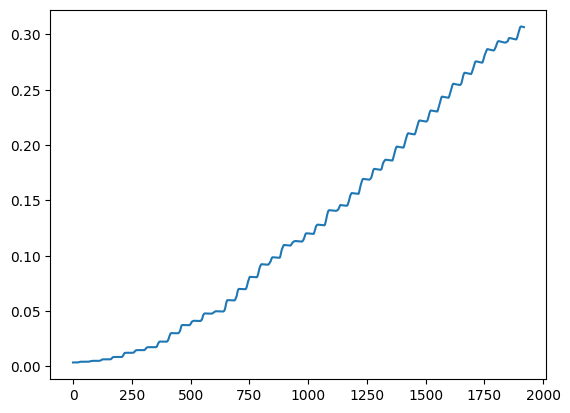

In [106]:
plt.plot (Y_log[:,0])

Total performance recieved from environment 4.175436918514922
Total reward recieved from evaluation 4.8047495496363295
Total penalties recieved from evaluation 0.6293126331141323
Total evaluted performance recieved from environment 4.175436916522197
----------------------------  --------------
EPI                (EURO/m2)     4.80659
Total growth       (kg/m2)       0.303034
Total C02 usage    (kg/m2)       1.03177
Total Heating      (kWh)        13.6605
Computational Time (s)           0.000201507
Temp violations    (deg)       119.202
C02 violations     (ppm)      1046.47
FINAL PERFORMANCE                4.17726
----------------------------  --------------


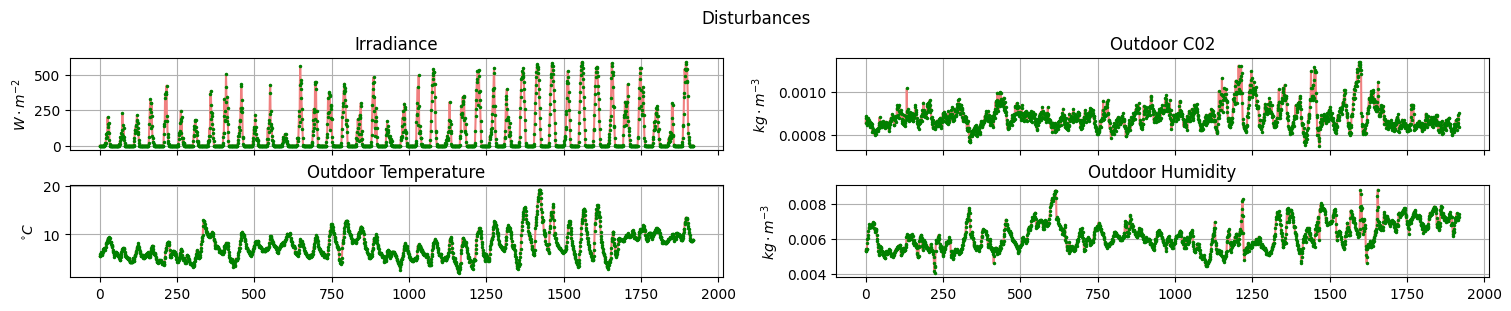

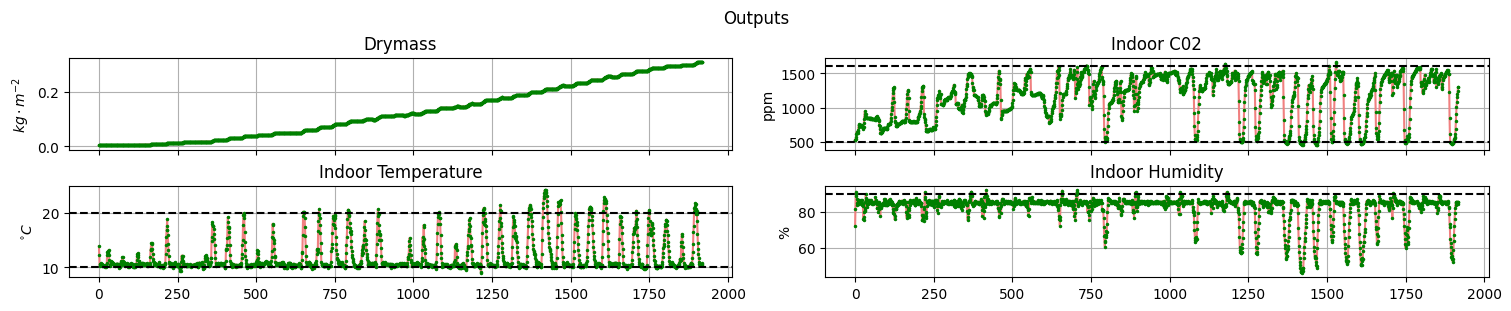

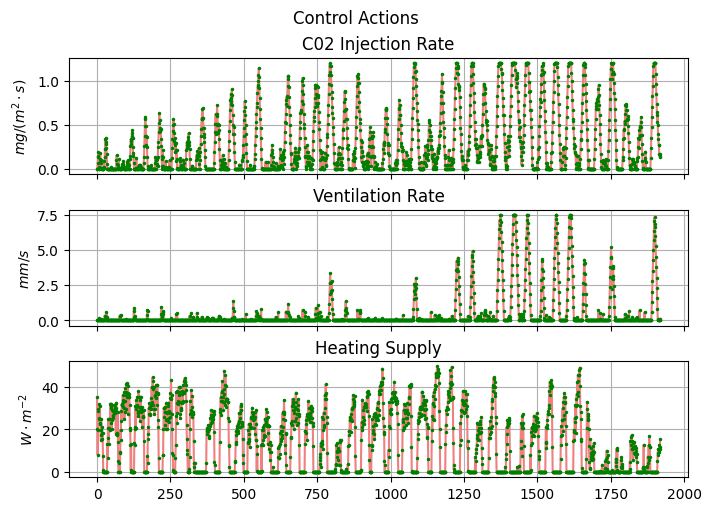

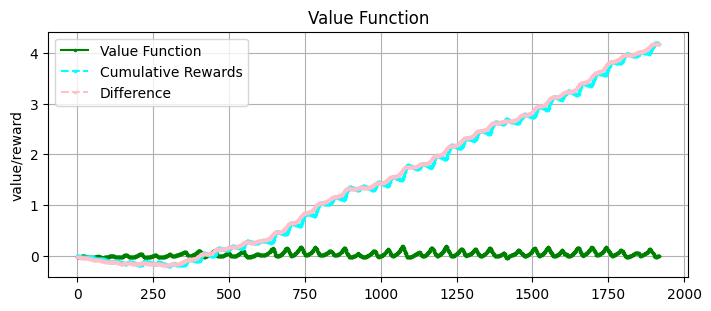

In [107]:
'''TRAINING EVALUATION'''
print (f"Total performance recieved from environment {total_reward}")
print (f"Total reward recieved from evaluation {total_reward_eval}")
print (f"Total penalties recieved from evaluation {total_penalty_eval}")
print (f"Total evaluted performance recieved from environment {total_reward_eval-total_penalty_eval}")


print_metrics(Y_log, U_log, D_log,vf=values,rewards=rewards_log,day_range=(0,40),time_log=comp_time_log)




In [108]:
'''MPC COMPARISON'''
# print_metrics(Y_log, U_log, D_log, rewards=cum_reward_log[:-1],day_range=(0,40))

'MPC COMPARISON'

Value Function Vis

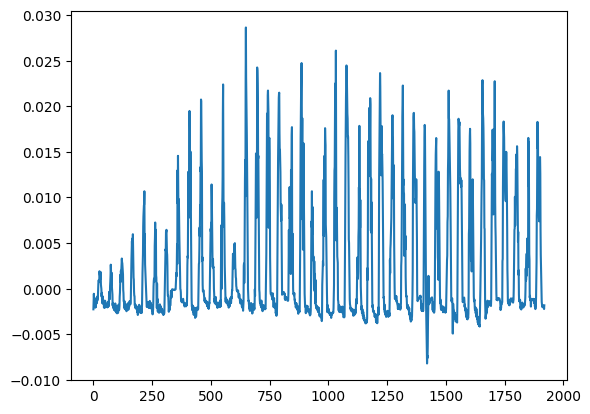

In [109]:
plt.plot(cost_log)

In [110]:
'''Growth rate'''
max_growth = 0.5
min_growth = 0
growth_range = np.linspace(min_growth,max_growth,20)


def vf_heatmap():
    vf_grid = np.zeros((len(growth_range),max_steps))
    for i in range(max_steps):
        for indx,growth in enumerate(growth_range):
            log = []
            for j in range (0,20):
                env.k = i
                obs,_,_ = env.sample_obs()
                obs[0] = growth
                obs_norm = env_norm.normalize_obs(obs)
                action, _states = model.predict(obs_norm, deterministic=True)
                obs_tensor,_ = model.policy.obs_to_tensor(obs_norm)
                action_tensor = torch.tensor(action, dtype=torch.float32)
                
                vf1 = model.policy.critic.q_networks[0](torch.cat([obs_tensor,action_tensor], dim = 1))
                value = vf1[0][0]
                log.append(value)
            
            vf_grid[indx][i] = np.mean(log)
            
    mask = np.arange(len(growth_range)) % 1 == 0
    yticks = np.where(mask, np.round(growth_range*1000,3), None)

    ax = sns.heatmap(vf_grid, yticklabels=yticks)

    ax.invert_yaxis()  # Invert y-axis on the heatmap object
    plt.show()


vf_heatmap()

AttributeError: 'DummyVecEnv' object has no attribute 'sample_obs'